## **3. Classic ML**

Загрузить датасет taxi.xls.

1) Изучить данные. Отобразить общую информацию по признакам. Описать свои наблюдения.

2) Выявить пропуски, а также возможные причины их возникновения. Решить, что следует сделать с ними. Описать свои наблюдения и решение.

3)	Оценить и описать зависимость переменных между собой.

4)	Определите стратегию преобразования категориальных признаков для дальнейшего построения моделей.

5)	Найти признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалить лишние, при необходимости.

6)	Разделить выборку на обучаемую и тестовую.

7)	Обучить несколько моделей, выбрать критерий оценки выбрать наилучшую.

8)	Визуализировать результаты.


Начнем нашу работу с импорта всего необходимого:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Импортируем все, что необходимое для работы с данными
import pandas as pd
import numpy as np

In [ ]:
#Импортируем графические библиотеки
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Импортируем необходимые инструменты SciPy
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt   
from scipy.spatial import distance 

In [ ]:
#Импортируем инструменты для изучения предикторов
from sklearn.feature_selection import SelectKBest,chi2,RFE

In [ ]:
#Импортируем инструменты для построения pipeline
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

In [ ]:
#Импортируем инструменты для кодировки и предобработки
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [ ]:
#Импортируем вспомогательные инструменты
from sklearn.manifold import TSNE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [ ]:
#Импортриуем алгоритмы кластеризации
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [ ]:
#Импортируем инстурменты для разделения и валидаций
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
#Импортируем метрики
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [ ]:
!pip install CatBoost

     |████████████████████████████████| 67.4 MB 25 kB/s 


In [ ]:
#Импортируем алгоритмы классификаторов
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

### **3.1 Анализ данных**

In [ ]:
#Создадим фрейм с данными
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SBER-TEST/taxi.csv')
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


Очевидно перед нами задача классификации, и предсказывать будем driver_response. Данное предсказание вероятно необходимо для ускорения работы сервиса такси. А так же для поощрения водителей дополнительными заказами.

Мы видим константные столбцы а именно offer_gk, driver_gk, order_gk. От данных столбцов нужно будет избавляться. 

Можно заметить координаты водителя и заказа вероятно необходимо будет считать Евклидово или Манхэттонское расстояния, а столбцы с координатами так же вероятно будем убирать. Значения необходимо будет сверить с distance, возможно это уже и есть одно из расстояний.

На текущий момент мы имеет следующие **категориальные** признаки:

weekday_key - Никак не будем изменять столбец

hour - Никак не будем изменять столбец

offer_class_group - Необходима кодировка

ride_type_desc - Необходима кодировка

На текущий момент мы имеет следующие **численные** признаки:

distance_km

duration_min - возможно переведем в часы

Как и писал выше - вероятно добавим новые столбцы - с расстоянием по координатам, а так же имеет смысл рассчитать скорость разделив distance_km на duration_min

После можно будет проверить корреляцию с целевым признаком.



In [ ]:
#Проверим размерность
df.shape

(100000, 14)

In [ ]:
#Проверим дубликаты
df.duplicated().sum()

0

Отлично, дубликаты в данных отсутствуют

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

С типами данных все в порядке. Пропусков на первыйвзгляд нет. Посмотрим на статистическаие данные

In [ ]:
#Проверим статистические данные
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


Интересно, мы можем заметить аномальные значения (-1) в координатах дистанции и длительности поездок. Вероятно это какая-то техническая ошибка. Она могла возникнуть по причине отсутствия сигнала со спутников, или при севшем телефоне. дистанция и длительность соответствтенно рассчитаться не могли. В реальной жизни я бы обратился к разработчикам или отделу который предоставил данные для уточнения причин появления таких значений.

Данные по расстоянию перекошены вправо, медиана - 10.411, а среднее 18.39
Длительности перекошена вправо, медиана - 19.7, а среднее 23.13

У нас есть аномальные значения, поездка болье 5000 км и длительность больше суток. От аномальных значений будем избавляться.

Давайте посмотрим, есть ли еще какие-то аномальные значения

In [ ]:
df.loc[df['driver_latitude']==0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
55260,271817,0,14,771,306124,0.0,0.0,55.410307,37.902451,43.726,55.45,Economy,private,0


In [ ]:
df.loc[df['driver_longitude']==0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
55260,271817,0,14,771,306124,0.0,0.0,55.410307,37.902451,43.726,55.45,Economy,private,0


Отлично у нас есть строчка, где у водителя нулевые координаты - ее можно выбросить, так как на фоне всего размера она не сыграет роли.

In [ ]:
df.loc[df['origin_order_latitude']==0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response


In [ ]:
df.loc[df['origin_order_longitude']==0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response


У нас нет нулевых значений в координатах заказов

In [ ]:
df.loc[df['distance_km']==0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
859,346101,4,12,4215,70206,55.758458,37.710545,55.747802,37.715600,0.0,0.0,Economy,private,1
1179,166480,5,8,1706,234100,55.787066,37.563235,55.792505,37.563787,0.0,0.0,Economy,private,1
2435,839922,3,12,6792,845047,55.415367,37.898310,55.410307,37.902451,0.0,0.0,Standard,private,1
2918,904433,5,18,1514,228992,55.681763,37.480773,55.671333,37.464131,0.0,0.0,Standard,private,0
3357,149416,4,6,4269,401598,55.961844,37.409798,55.961995,37.406355,0.0,0.0,Economy,private,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97780,891112,0,23,6302,240143,55.964894,37.413532,55.962322,37.407117,0.0,0.0,Standard,private,0
98847,1076090,1,0,2442,607562,55.961366,37.413864,55.962322,37.407117,0.0,0.0,Standard,private,0
99280,325512,4,23,2442,690788,55.961371,37.413497,55.962322,37.407117,0.0,0.0,Standard,private,0
99937,213143,1,0,2442,378241,55.961366,37.413864,55.962322,37.407117,0.0,0.0,Economy,private,0


А вот с дистанцией и временем интересно. Дистанцию мы можем заполнить медианой или средним, а длительность можем получить используя среднеюю скорость водителя (её можем получить через driver_gk по другим заказам).

Ну и проверим сколько у нас отрицателньых значений:

In [ ]:
df.loc[df['driver_latitude']<0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
565,638186,5,14,6272,817074,-1.0,-1.0,55.908664,37.597781,-1.000,-1.00,Standard,business,1
2111,567790,1,12,6792,820788,-1.0,-1.0,55.415361,37.898917,-1.000,-1.00,Standard,business,1
2129,302376,1,1,6792,548327,-1.0,-1.0,55.415361,37.898917,83.923,81.35,Standard,business,1
2137,427612,6,21,6792,32158,-1.0,-1.0,55.415361,37.898917,-1.000,-1.00,Standard,business,1
2142,202875,6,3,6792,346671,-1.0,-1.0,55.415361,37.898917,70.529,65.00,Standard,business,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81694,698969,6,6,2470,862514,-1.0,-1.0,55.699097,37.317988,41.576,43.55,Standard,private,1
83631,1077757,1,7,5578,62551,-1.0,-1.0,55.600737,37.539690,-1.000,-1.00,Delivery,business,1
85335,75929,5,14,468,776944,-1.0,-1.0,55.387756,37.549058,-1.000,-1.00,Standard,business,1
89970,1110601,6,13,259,135435,-1.0,-1.0,55.962322,37.407117,-1.000,-1.00,Standard,business,1


Всего 140 строк на фоне Объема данных это 1,4% Я думаю ими можно принебречь.

In [ ]:
#Посмотрим на уникальные значения категориальных предикторов и проверим
df['offer_class_group'].unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Test', 'Premium',
       'VIP', 'VIP+'], dtype=object)

In [ ]:
df['ride_type_desc'].unique()

array(['private', 'business', 'affiliate', 'SMB'], dtype=object)

Думаю, что будем использовать OE - кодирование для категориальных переменных - это позволит нам не увеличивать размерность датасета. Но нужно учитывать, что при такой кодировке алгоритм логистической регрессии будет показывать себя не с лучшей стороны.

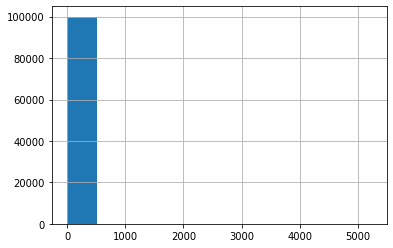

In [ ]:
#Посмотрим как распределены наши численные признаки
df['distance_km'].hist()

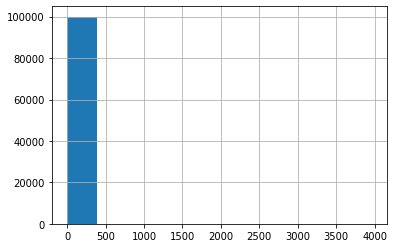

In [ ]:
df['duration_min'].hist()

Видим, что у нас есть выбросы и в длительности и в расстоянии. Проверим.

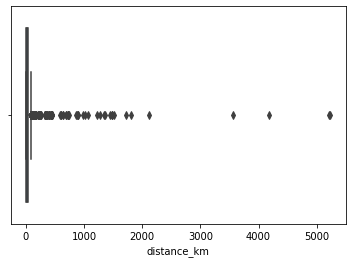

In [ ]:
#Проверим выбросы в данных
sns.boxplot(data=df, x=('distance_km'))

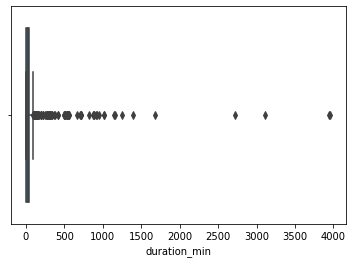

In [ ]:
sns.boxplot(data=df, x=('duration_min'))

От выбросов необходимо будет избавиться.


Text(0.5, 1.0, 'Correlation Heatmap')

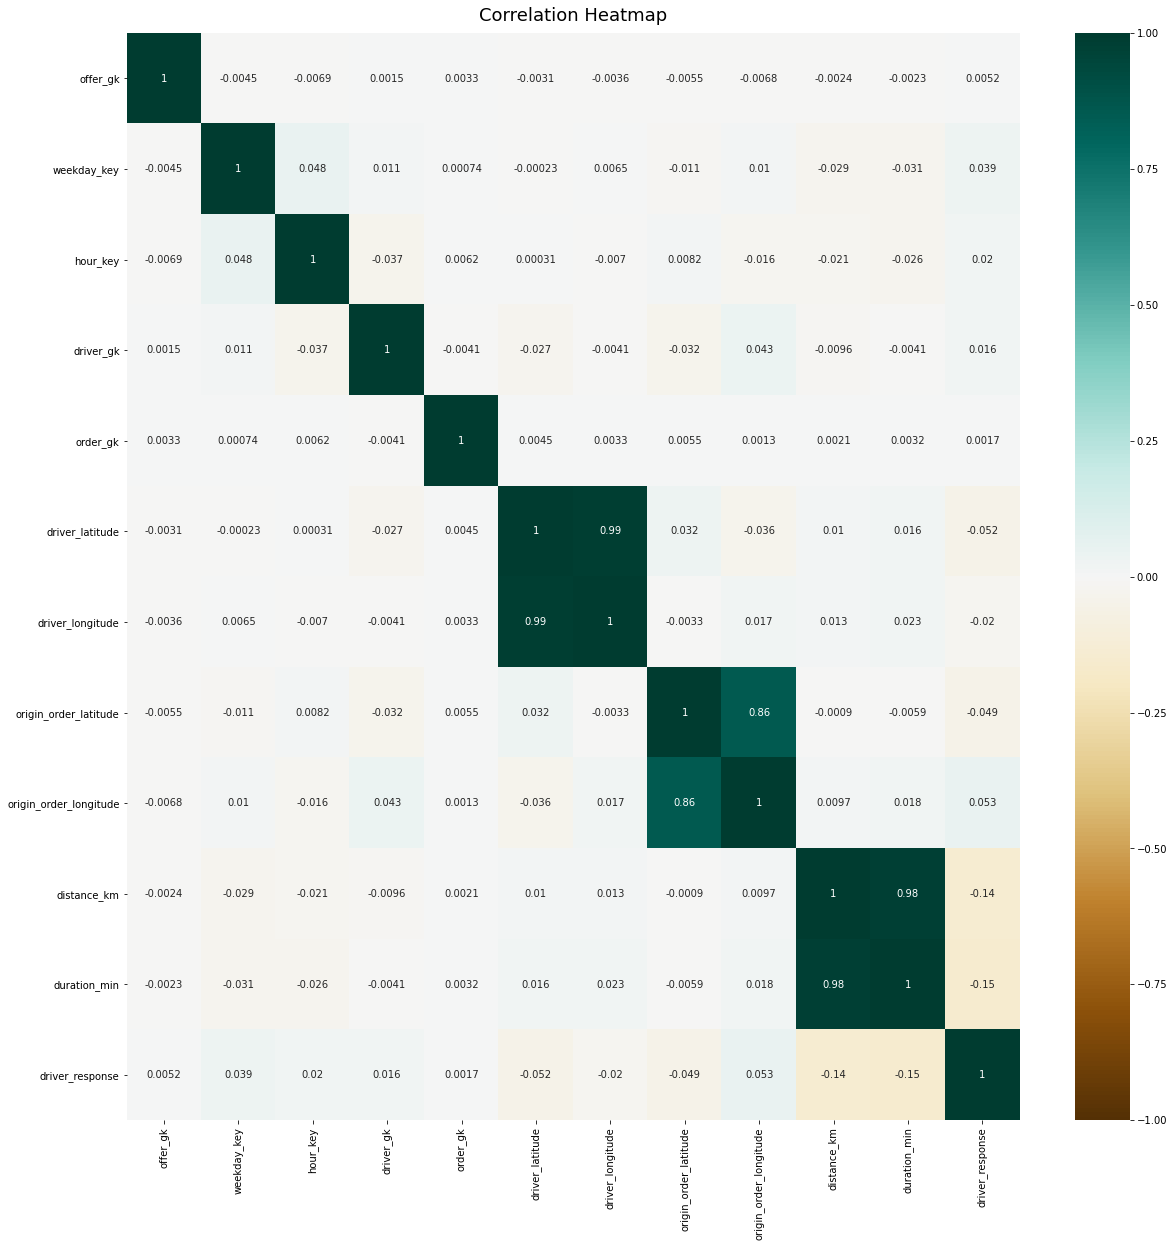

In [ ]:
#Построим correlation heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Можно заметить, что у нас нет сильных линейных зависимостей. Требуется чистка данных и создание дополнительных признаков.

**Вывод:**
Последовательность нашей работы следующаяя:

**Предобработка данных:**
1. Мы уберем все аномальные значения и выбросы
2. Создадим столбец с манхэттэнским расстоянием
3. Создадим столбец со скоростью 
4. Заменим нулевые значения на NaN 
5. Заполним distance медианным значением (снизим влияние выборосов)
6. Заполним duration при помощи скорости
7. Уберем все лишние столбцы
8. Проверим корреляции и взаимосвязь между признаками
9. Проверим баланс классов
10. Мы создадим пайплайн для OЕ
11. Мы создадим класс который займется преобразованием наших данных
12. Мы разделим выборки на тренировочную и тестовую.


**Обучение моделей:**
1. Выберем метрику
2. При помощи GridSearch подберем лучшие гиперпараметры моделей и обучим их.

**Анализ моделей:**
1. Проанализируем показатели наилучшей модели и выберем её. 
2. Проанализируем значимость предикторов.

**Оптимизация:**
Уменьшим обучающую выборку на основе анализа.

**Обучение финальной модели:**
Обучим лучшую модель на оптимизированной выборке и сравним результаты

**Сделаем финальный вывод**

### **3.2 Предобработка данных и feature engineering**

Начнем нашу работу по предобработке и чистке данных. Будем убирать аномальные значения

In [ ]:
#Оставим координаты больше нуля
df=df.loc[df['driver_latitude']>0]
df=df.loc[df['origin_order_latitude']>0]
#Проверим
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,9.984600e+04,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000
mean,5.661606e+05,3.160087,13.826633,3445.159676,460917.356649,55.780883,37.546631,55.780195,37.546311,18.411756,23.159030,0.491757
std,3.259388e+05,2.054477,7.308449,2038.548277,266050.549822,0.153851,0.157053,0.156106,0.159887,41.150869,33.901266,0.499935
min,4.000000e+00,0.000000,0.000000,14.000000,18.000000,55.327636,36.984771,55.327917,36.994072,-1.000000,-1.000000,0.000000
25%,2.855075e+05,1.000000,8.000000,1421.000000,229222.250000,55.709285,37.413497,55.708502,37.407117,-1.000000,-1.000000,0.000000
50%,5.655655e+05,3.000000,16.000000,3506.000000,462534.000000,55.773085,37.533874,55.772734,37.532189,10.441500,19.750000,0.000000
75%,8.486678e+05,5.000000,20.000000,5242.000000,690894.000000,55.960697,37.624235,55.962035,37.624145,30.694750,37.883000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


In [ ]:
df.shape

(99846, 14)

Отлично нам удалось убрать аномалии, почти непотеряв в объеме.



In [ ]:
#Заменим 0 и -1 на NaN в дистанции и длительности
df.loc[(df['distance_km'] == -1) | (df['distance_km'] == 0) , 'distance_km'] = np.nan
df.loc[(df['duration_min'] == -1) | (df['duration_min'] == 0) , 'duration_min'] = np.nan

#Проверим
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,9.984600e+04,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,99846.000000,73611.000000,73611.000000,99846.000000
mean,5.661606e+05,3.160087,13.826633,3445.159676,460917.356649,55.780883,37.546631,55.780195,37.546311,25.328051,31.767257,0.491757
std,3.259388e+05,2.054477,7.308449,2038.548277,266050.549822,0.153851,0.157053,0.156106,0.159887,45.987735,35.733557,0.499935
min,4.000000e+00,0.000000,0.000000,14.000000,18.000000,55.327636,36.984771,55.327917,36.994072,0.005000,0.017000,0.000000
25%,2.855075e+05,1.000000,8.000000,1421.000000,229222.250000,55.709285,37.413497,55.708502,37.407117,7.960500,16.617000,0.000000
50%,5.655655e+05,3.000000,16.000000,3506.000000,462534.000000,55.773085,37.533874,55.772734,37.532189,18.667000,28.217000,0.000000
75%,8.486678e+05,5.000000,20.000000,5242.000000,690894.000000,55.960697,37.624235,55.962035,37.624145,38.785000,44.367000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.174097,38.280547,56.172361,38.243608,5234.283000,3958.283000,1.000000


In [ ]:
#Добавляем столбец с длительностью в часах
df['duration_h']=df['duration_min']/60

Создадим столбец с манхтэттэнским расстоянием - дистанция до клиента может иметь значение при принятии решения о принятии заказа.

In [ ]:
#Вычислим манхеттэннское расстояние между таксистом и клиентом
df['man_distance']=abs(df['driver_latitude']-df['origin_order_latitude'])+abs(df['driver_longitude']-df['origin_order_longitude'])

In [ ]:
#Создадим столбец со скоростью
df['speed']=df['distance_km']/df['duration_h']

In [ ]:
#Заполним скорость средним значением по водителю
df['speed']=df['speed'].fillna(df.groupby(['driver_gk'])['speed'].transform('mean'))

In [ ]:
#Заполним distance средним значением по клиенту
df['distance_km']=df['distance_km'].fillna(df.groupby(['order_gk'])['distance_km'].transform('mean'))

#Единичные пропуски заполним средним
df['distance_km']=df['distance_km'].fillna(df['distance_km'].mean())

In [ ]:
#Заполним длительность поездки рассчетныйм значением
df['duration_h']=df['duration_h'].fillna(df['distance_km']/df['speed'])

In [ ]:
#Создадим пределы
LIMIT_DISTANCE=30.69475+(30.69475-11.045250)


In [ ]:
#Уберем выбросы
df=df.loc[df['distance_km']<LIMIT_DISTANCE]

#Проверим
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response,duration_h,man_distance,speed
count,9.082900e+04,90829.000000,90829.000000,90829.000000,90829.000000,90829.000000,90829.000000,90829.000000,90829.000000,90829.000000,64594.000000,90829.00000,90829.000000,90829.000000,90829.000000
mean,5.658992e+05,3.187033,13.930419,3443.817867,461152.750718,55.786507,37.540324,55.786066,37.539682,21.045698,26.949091,0.52219,0.514301,0.015978,38.465779
std,3.256436e+05,2.040984,7.138702,2030.191262,265920.018282,0.138885,0.145622,0.140634,0.147873,12.319143,14.089966,0.49951,0.235849,0.015400,12.581032
min,4.000000e+00,0.000000,0.000000,14.000000,18.000000,55.327636,36.984771,55.327917,36.994072,0.005000,0.017000,0.00000,0.000283,0.000000,2.333052
25%,2.856550e+05,1.000000,9.000000,1421.000000,229434.000000,55.718470,37.413532,55.718743,37.407117,9.958000,15.350000,0.00000,0.319167,0.006516,29.606107
50%,5.648830e+05,3.000000,16.000000,3506.000000,463998.000000,55.772270,37.536057,55.771861,37.535077,25.328051,25.000000,1.00000,0.499378,0.010832,36.150703
75%,8.477360e+05,5.000000,20.000000,5222.000000,690731.000000,55.937080,37.619269,55.941661,37.618649,25.328051,37.700000,1.00000,0.728050,0.021138,50.069601
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.000000,56.174097,38.280547,56.172361,38.243608,50.343000,76.550000,1.00000,1.275833,0.408365,87.961872


In [ ]:
#Убираем все ненужные столбцы
df.drop(['offer_gk', 'driver_gk', 'order_gk','driver_latitude','driver_longitude', 'origin_order_latitude', 'origin_order_longitude', 'duration_min'], axis=1, inplace=True)

1    0.52219
0    0.47781
Name: driver_response, dtype: float64

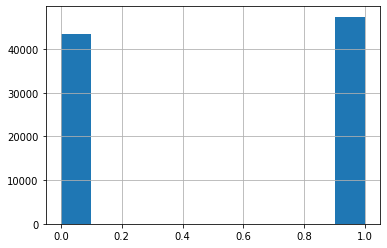

In [ ]:
#Проверим баланс классов
class_frequency=df['driver_response'].value_counts(normalize=2/len(df))
df['driver_response'].hist()
class_frequency

Отлично, классы почти в балансе.

Text(0.5, 1.0, 'Correlation Heatmap')

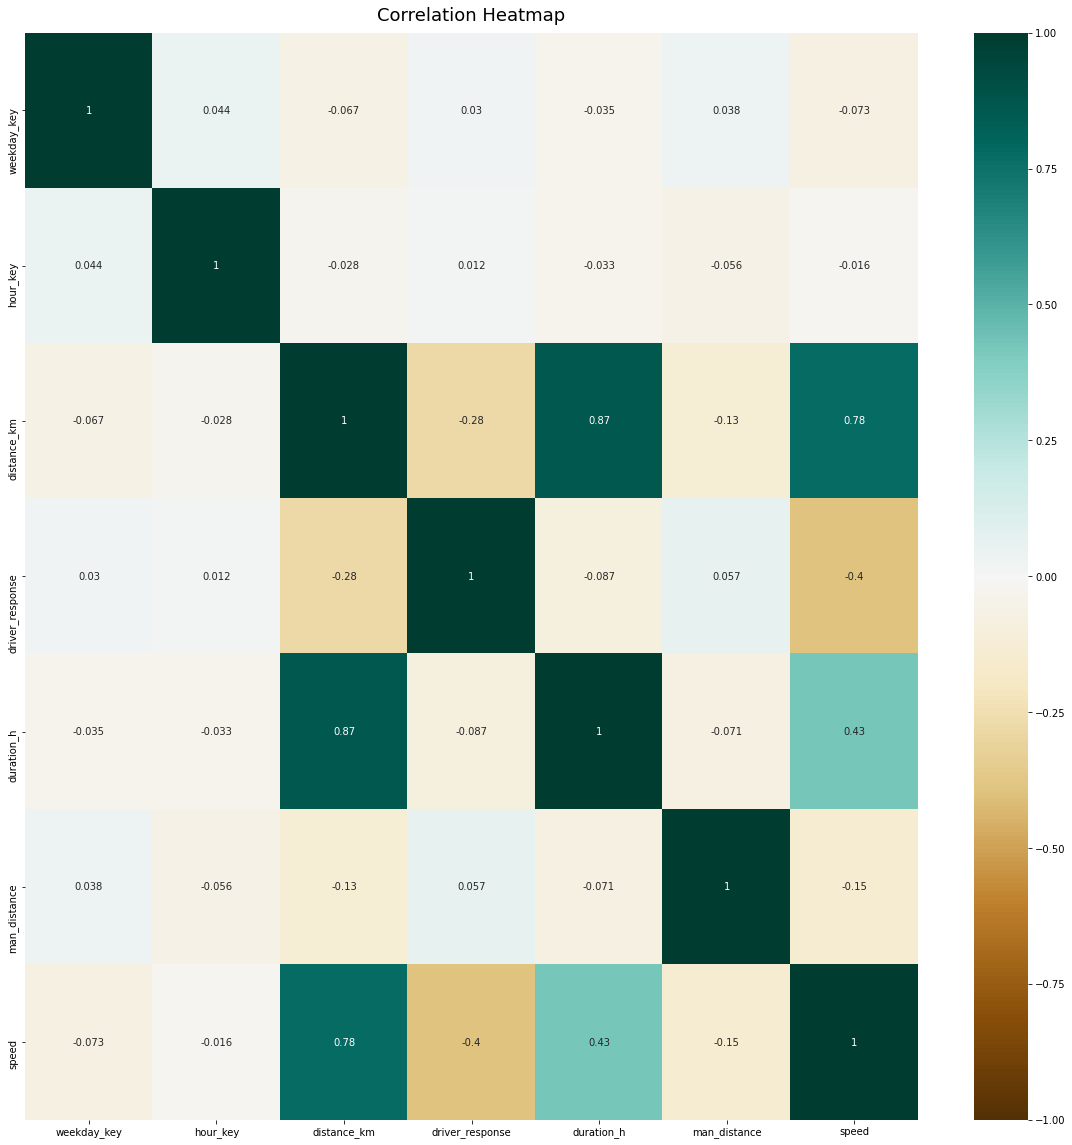

In [ ]:
#Построим correlation heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Можно заметить, что нам удалось серьезно улучшить положение, у нас умеренная обратная корреляция целевого признака со скоростью и обратная корреляция с расстоянием

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ed3f8fbd0>,
      dtype=object)

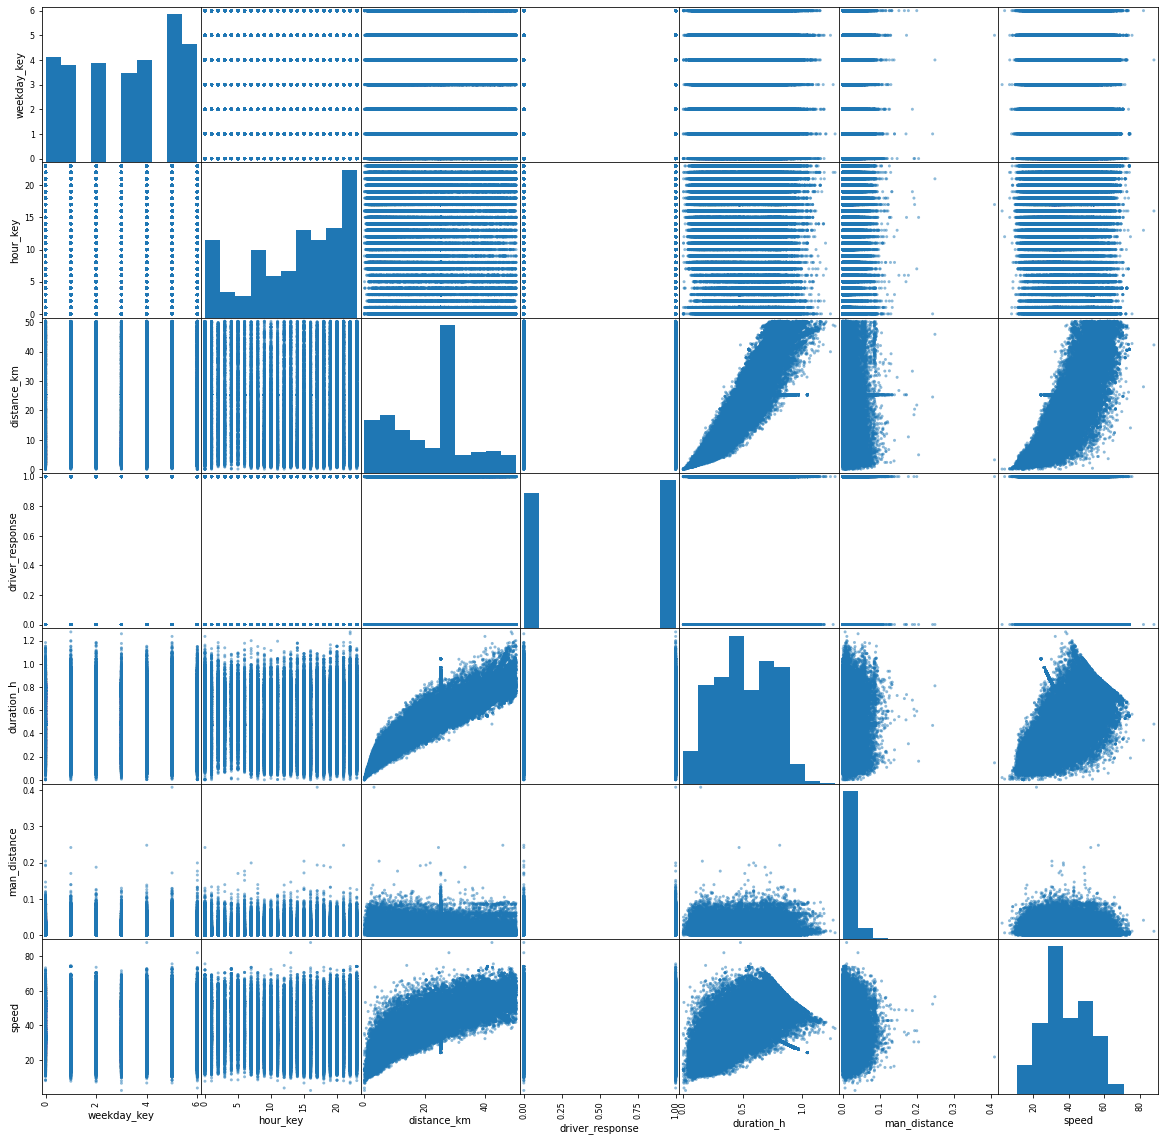

In [ ]:
#Посмотрим как распределены данные и как распределены признаки относительно друг друга
pd.plotting.scatter_matrix(df, figsize=(20,20))

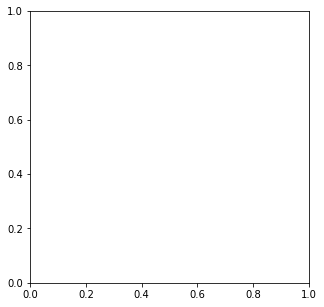

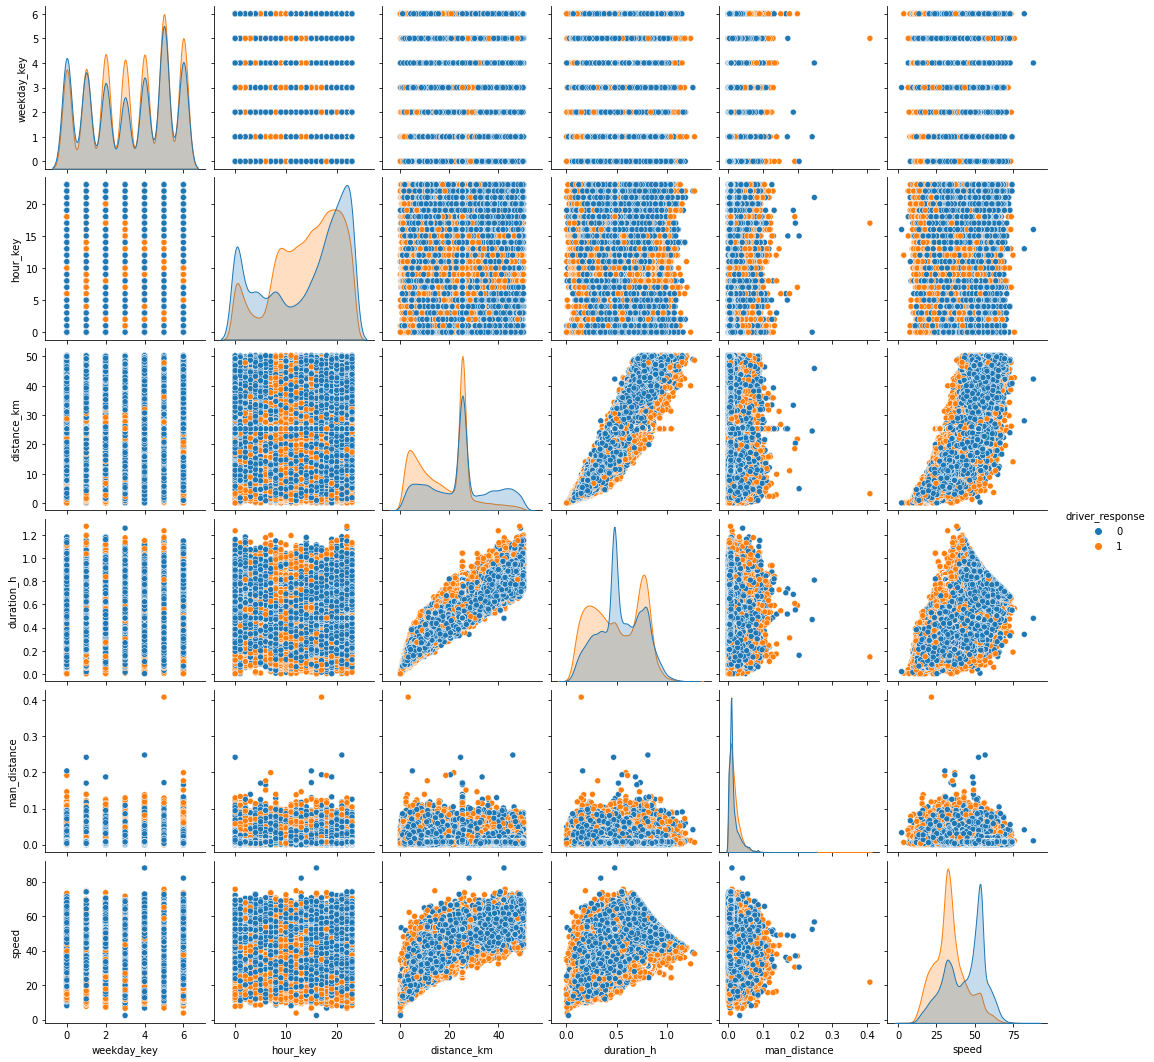

In [ ]:
#Проверим как распределен целевой признак
a4_dims = (5, 5)
fig, ax = plt.subplots(figsize=a4_dims)

graph3 = sns.pairplot(df, hue ='driver_response')

Можно заметить, что комбинация некоторых признаков может помочь в классификации напишем функцию для генерации новых признаков.

Начнем создавать свои классы и создавать пайплайны

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
  '''Данный класс извлекает и возвращает набор данных с теми столбцами, имена которых были переданы в качестве аргумента при инициализации'''
  #Инициализируем класс
  def __init__(self, feature_names):
        self._feature_names = feature_names 
  
  #Поставим заглушку
  def fit(self, X, y = None):
        return self 

  #Вывод набора данных
  def transform(self, X, y = None):
        return X[self._feature_names].values 

print('Строка документации: \n', FeatureSelector.__doc__)        

Строка документации: 
 Данный класс извлекает и возвращает набор данных с теми столбцами, имена которых были переданы в качестве аргумента при инициализации


Теперь нам нужно создать дополнителньый класс преобразователь, для генерирования новых признаков.


In [ ]:
#Cоздаем класс-трансформер для создания дополнительных категориальных признаков созданных на основе кластеризации. 
class CustomTransform(BaseEstimator, TransformerMixin):
  '''Трансформер работает в 3 шага:
  1) При помощи TSNE - снижает размерность пространства 
  2) По новым данным происходит кластеризация при помощи DBSCAN, лэйблами кластера заполняется новая категория "DB"
  3) При помощи KMeans происходит дополнительная кластеризация, и генерируется еще 6 новых признаков
  В результате мы получаем фрейм с 7ью новыми категориальными признаками.
  '''
  def fit( self, X, y = None ):
        return self    

  def transform(self, X, y = None):

    print('begin tsne transform')
    #Снижаем размерность пространства
    tsne = TSNE(learning_rate=100, n_jobs=-1)    
    emb = tsne.fit_transform(X)
    x_axis = emb[:, 0]
    y_axis = emb[:, 1]
    print('begin dbscan clastering')
    #делим на то количество кластеров какое получится
    dbscan = DBSCAN(eps=1.42, min_samples=15, n_jobs=-1, leaf_size=30, p=None)
    dbscan.fit(emb)
    df_clast = pd.DataFrame()
    df_clast['DB'] = dbscan.labels_
    
    print('begin KMeans clastering')
    k3 = KMeans(n_clusters=3, precompute_distances = True, n_jobs=-1)
    k3.fit(X)
    k5 = KMeans(n_clusters=5, precompute_distances = True, n_jobs=-1)
    k5.fit(X)
    k10 = KMeans(n_clusters=10, precompute_distances = True, n_jobs=-1)
    k10.fit(X)
    k14 = KMeans(n_clusters=14, precompute_distances = True, n_jobs=-1)
    k14.fit(X)
    k17 = KMeans(n_clusters=17, precompute_distances = True, n_jobs=-1)
    k17.fit(X)
    k21 = KMeans(n_clusters=21, precompute_distances = True, n_jobs=-1)
    k21.fit(X)
    a = pd.Series(k3.predict(X))
    b = pd.Series(k5.predict(X))
    c = pd.Series(k10.predict(X))
    d = pd.Series(k14.predict(X))
    e = pd.Series(k17.predict(X))
    f = pd.Series(k21.predict(X))
    
    df_clast['k3'] = a
    df_clast['k5'] = b
    df_clast['k10'] = c
    df_clast['k14'] = d
    df_clast['k17'] = e
    df_clast['k21'] = f
 
    X=pd.DataFrame(X)
    X=pd.concat([X, df_clast],axis=1)
    
    return X

print('Строка документации: \n', CustomTransform.__doc__)    

Строка документации: 
 Трансформер работает в 3 шага:
  1) При помощи TSNE - снижает размерность пространства 
  2) По новым данным происходит кластеризация при помощи DBSCAN, лэйблами кластера заполняется новая категория "DB"
  3) При помощи KMeans происходит дополнительная кластеризация, и генерируется еще 6 новых признаков
  В результате мы получаем фрейм с 7ью новыми категориальными признаками.
  


Отлично, теперь нам необходимо построить пайплайны.

Для заполнения пропусков числовых переменных мы будем использовать среднюю.
Так же мы будем использовать StandardScaler, но непосредственно перед обучением модели, чтобы избежать утечек, так как наш искусственный трансформер должен принять выборку до разделения на тестовую и тренировочную, чтобы выборки получились одинакового размера

Для кодировки категориальных признаков мы будем использовать OE 

In [ ]:
#Создадим фреймы с целевой переменной и признаками:
y = df['driver_response']
X = df.drop(['driver_response'], axis=1)

In [ ]:
#Cоздадим лист категориальных признаков
cuts = ['weekday_key', 'hour_key', 'offer_class_group',	'ride_type_desc']

#Создадим список количественных признаков    
nums = ['distance_km', 'duration_h', 'man_distance', 'speed']

In [ ]:
#Строим pipeline для категориальных признаков
categorical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(cuts)),
                                     ('encoder', OrdinalEncoder())]) 

#Строим pipeline для числовых признаков
numerical_pipeline=Pipeline(steps=[('cat_selector', FeatureSelector(nums))])


#Объединяем
all_features=FeatureUnion(transformer_list=[('categorical_pipeline', categorical_pipeline), 
                                            ('numerical_pipeline', numerical_pipeline)])   

#Добавляем в pipeline CustomTransform
full_pipeline=Pipeline(steps=[('all_features', all_features),
                              ('custom_transform', CustomTransform())])                          

In [ ]:
X=full_pipeline.fit_transform(X)

begin tsne transform
begin dbscan clastering
begin KMeans clastering


In [ ]:
#Разделим выборки на тестовую и тренировочную с использованием stratify, так как у нас есть легкий дисбаланс
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 1123, stratify=y)

Проверим размерности:

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(68121, 15) (68121,)
(22708, 15) (22708,)


Все поулчилось, мы можем приступать к обучению моделей.

### **3.3 Machine Learning**

Выбор метрики играет очень важную роль при выборе модели. Accuracy  не помогает при несбалансированном целевом признаке (у нас легкий дисбаланс). 

В нашей задаче важно точно определить водителя который согласится, чтобы быстрее предложить ему заказ, а так же назначить водителя клиенту. Следовательно нам нужно предсказать как можно большее количество TP из всех положительных меток класса. Будем использовать recall


Перед началом работы напишу вспомогательные функцию для вычисления ключевой метрики на тренировочной и тестовой выборках

In [ ]:
def recall_metric(model, X, y):
    '''Высчитывает recall модели на переданных данных
    
    Аргументы: 
                model: sklearn обученная модель
                X - выборка для предсказания
                y - выборка с реальным целевым признаком
    Возвращает:
                metric: recall между реальным целевым и предсказанным признаками
    '''
   
    
    metric = 0
    
    y_pred = model.predict(X)
    
    metric = metrics.recall_score(y, y_pred)
    
    return metric
print('Строка документации: \n', recall_metric.__doc__)

Строка документации: 
 Высчитывает recall модели на переданных данных
    
    Аргументы: 
                model: sklearn обученная модель
                X - выборка для предсказания
                y - выборка с реальным целевым признаком
    Возвращает:
                metric: recall между реальным целевым и предсказанным признаками
    


In [ ]:
def ev_model(model, X_train, y_train, X_test, y_test, scale=False):
    '''Обучает модель на тренировочной выборке, после вычисляет recall
    на тренировочной и тестовой выборках
    
    Аргументы: 
                model: sklearn НЕ обученная модель
                X_train: выборка для обучения
                y_train: выборка c целевым признаком обучающей выборки
                X_test: тестовя выборка для предсказания
                y_test: выборка c целевым признаком тестовой выборки
                scale: Масштабирование данных перед обучением
    Возвращает:
                metric_train: float, recall тренировочной выборки
                metric_test: float, recall тестовой выборки

    '''
    
    metric_train = 0
    metric_test = 0

    if (scale == True):
      
      sc = StandardScaler()

      X_train = sc.fit_transform(X_train)
      
      X_test = sc.transform(X_test)

    model.fit(X_train, y_train)
  
    metric_train = recall_metric(model, X_train, y_train)

    metric_test = recall_metric(model, X_test, y_test)
    
    return metric_train, metric_test
print('Строка документации: \n', ev_model.__doc__)

Строка документации: 
 Обучает модель на тренировочной выборке, после вычисляет recall
    на тренировочной и тестовой выборках
    
    Аргументы: 
                model: sklearn НЕ обученная модель
                X_train: выборка для обучения
                y_train: выборка c целевым признаком обучающей выборки
                X_test: тестовя выборка для предсказания
                y_test: выборка c целевым признаком тестовой выборки
                scale: Масштабирование данных перед обучением
    Возвращает:
                metric_train: float, recall тренировочной выборки
                metric_test: float, recall тестовой выборки

    


#### **3.3.1 RandomForest**

In [ ]:
#Найдем наилучшие гиперпараметры RandomForest
#Строим pipeline
pipe_ =  RandomForestClassifier()

#Зададим параметры для gridsearch 
param_grid = {
    'n_estimators' : list(range(1,50)),
    'class_weight' : ['balanced'],
    'max_depth' : list(range(1,8)), 
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':['gini', 'entropy']
    }

#Проведем исследование
scv = KFold(n_splits=5)

RF_model_GSCV = GridSearchCV(pipe_, param_grid = param_grid, scoring = 'recall', cv = scv, verbose=True, n_jobs=-1)

best_clf_RF = RF_model_GSCV.fit((StandardScaler().fit_transform(X_train)), y_train)

print('best parameters (CV recall score =%0.3f):' % best_clf_RF.best_score_)

print("best model:\n", best_clf_RF.best_params_)

Fitting 5 folds for each of 2058 candidates, totalling 10290 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 86.9min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 110.6min


best parameters (CV f1 score =0.891):
best model:
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'auto', 'n_estimators': 1}


[Parallel(n_jobs=-1)]: Done 10290 out of 10290 | elapsed: 120.1min finished


Мы получили лучшие гиперпараметры и теперь можем измерить разницу ключевой метрики на тренировочной и тестовой выбоках.

In [ ]:
#Воспользуемся нашими функциями и проверим лучшую модель на тренировочной и тестовой выборках
RF_CLF_recall_report=ev_model(RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=3, max_features='auto', n_estimators=11), X_train, y_train, X_test, y_test, scale=True)

print('recall лучшей модели на тренировочной выборке= %0.3f:' %RF_CLF_recall_report[0])
print('recall лучшей модели на тестовой выборке= %0.3f:' %RF_CLF_recall_report[1])

recall лучшей модели на тренировочной выборке= 0.858:
recall лучшей модели на тестовой выборке= 0.863:


#### **3.3.2 CatBoostClassifier**

In [ ]:
#Найдем лучшие параметры моедли и воспользуемся лучшей моделью

model = CatBoostClassifier(class_weights=[0.1, 4])

parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 100)
             }
scv = StratifiedKFold(n_splits=5)
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                           scoring = 'recall', 
                           cv = scv, n_iter = 10, n_jobs=-1)

randm.fit((StandardScaler().fit_transform(X_train)), y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")

0:	learn: 0.6755825	total: 76.5ms	remaining: 6.65s
1:	learn: 0.6586820	total: 92.8ms	remaining: 3.99s
2:	learn: 0.6424031	total: 109ms	remaining: 3.09s
3:	learn: 0.6267593	total: 125ms	remaining: 2.62s
4:	learn: 0.6115915	total: 138ms	remaining: 2.29s
5:	learn: 0.5970385	total: 154ms	remaining: 2.11s
6:	learn: 0.5829600	total: 170ms	remaining: 1.97s
7:	learn: 0.5693985	total: 200ms	remaining: 2s
8:	learn: 0.5563139	total: 222ms	remaining: 1.95s
9:	learn: 0.5436425	total: 237ms	remaining: 1.85s
10:	learn: 0.5313728	total: 248ms	remaining: 1.74s
11:	learn: 0.5195433	total: 265ms	remaining: 1.68s
12:	learn: 0.5080607	total: 285ms	remaining: 1.64s
13:	learn: 0.4969224	total: 296ms	remaining: 1.56s
14:	learn: 0.4862112	total: 311ms	remaining: 1.51s
15:	learn: 0.4758109	total: 325ms	remaining: 1.46s
16:	learn: 0.4657398	total: 341ms	remaining: 1.42s
17:	learn: 0.4559704	total: 356ms	remaining: 1.39s
18:	learn: 0.4465172	total: 372ms	remaining: 1.35s
19:	learn: 0.4372985	total: 385ms	remainin

In [ ]:
CB_CLF_recall_report = recall_metric(randm.best_estimator_, X_test, y_test)
print('recall лучшей модели на тестовой выборке= %0.3f' % CB_CLF_recall_report)

recall лучшей модели на тестовой выборке= 1.000


In [ ]:
feat=randm.best_estimator_.calc_feature_statistics(X_train, y_train, feature=2, plot=True)

К сожаленю визуализация от CatBoos не работает в Colab =( вот ссылка: https://coderoad.ru/59009938/%D0%9A%D0%B0%D0%BA-%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D1%8C-%D1%81%D1%8E%D0%B6%D0%B5%D1%82-catboost-%D0%B2-google-colab

Поэтому я приведу картинку из Jupyter Notebook (Там все обучить к сожалению не успел, Grid Search и кластеризация очень жадные. Вот картинка:
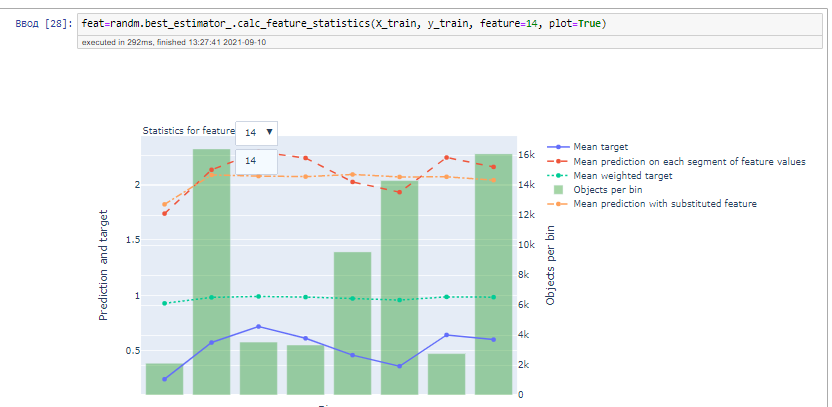

на изображении видно, чтографик среднего предсказания модели достаточно точно повторяет средний график целевого признака.

Так же ниже приведу пример Важности фич при помощи Random Forest

Feature: 0, Score: 0.00024
Feature: 1, Score: 0.01820
Feature: 2, Score: 0.01558
Feature: 3, Score: 0.00049
Feature: 4, Score: 0.03779
Feature: 5, Score: 0.01782
Feature: 6, Score: 0.02165
Feature: 7, Score: 0.31688
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.39050
Feature: 10, Score: 0.04673
Feature: 11, Score: 0.04567
Feature: 12, Score: 0.01827
Feature: 13, Score: 0.05386
Feature: 14, Score: 0.01632


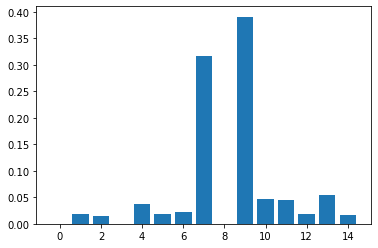

In [ ]:
model_RF=RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=3, max_features='auto', n_estimators=11)
model_RF.fit((StandardScaler().fit_transform(X_train)), y_train)

importance = model_RF.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,DB,k3,k5,k10,k14,k17,k21
52349,6.0,22.0,4.0,2.0,25.328051,0.674376,0.010720,37.557753,1,2,2,1,6,6,11
23394,6.0,17.0,4.0,3.0,25.328051,0.466178,0.007121,54.331248,1,0,0,2,9,0,12
88763,2.0,21.0,1.0,2.0,25.328051,0.472227,0.010460,53.635329,1,0,0,2,9,0,12
13888,1.0,16.0,1.0,3.0,15.137000,0.412217,0.028589,36.720980,1,2,2,9,7,7,7
70528,5.0,1.0,4.0,3.0,25.328051,0.655730,0.003478,38.625733,1,2,4,6,13,12,15


#### **3.3.3 Оптимизация**

Имеем следующие результаты recall по моделям на тестовой выборке:


In [ ]:
print('RandomForest: recall лучшей модели на тестовой выборке=%0.3f:' %RF_CLF_recall_report[1])
print('CatBoost: recall лучшей модели на тестовой выборке= %0.3f' % CB_CLF_recall_report)

RandomForest: recall лучшей модели на тестовой выборке=0.863:
CatBoost: recall лучшей модели на тестовой выборке= 1.000


Видим, что Cat_boost имеет Recall = 1 - Это лучший результат который только можно получить на выборке.

Так же важно отметить, что для RandomForest - Сгенерированный кастомным классификатором признак К3 - играет важную роль, наряду с признаком 7 (скорость). 

In [ ]:
#Создадим оптимизированную выборку для обучения модели и теста
X_opt=X_train[[7,'k3']]
X_opt_test=X_test[[7,'k3']]

In [ ]:
#Воспользуемся нашими функциями и проверим лучшую модель на тренировочной и тестовой выборках
RF_CLF_recall_report=ev_model(RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=3, max_features='auto', n_estimators=11), X_opt, y_train, X_opt_test, y_test, scale=True)

print('recall лучшей модели на тренировочной выборке= %0.3f:' %RF_CLF_recall_report[0])
print('recall лучшей модели на тестовой выборке= %0.3f:' %RF_CLF_recall_report[1])

recall лучшей модели на тренировочной выборке= 0.846:
recall лучшей модели на тестовой выборке= 0.849:


Как можно зметить, мы сильно упростили модель, оставив 2 ключевых предиктора при этом мы почти не потеряли метрику. Разница составила 0.014 на тестовых выборках. 

### **3.4 Итоговый вывод:**

В процессе работы мы познакомились и достаточно подробно изучили данные.
Нам удалось обнаружили пропуски в числовых данных, а так же провести исследовательский анализ данных. Мы разобрались как заполнять пропуски. Создали несколько новых предикторов.
Так же в процессе исследования было подмечено, что комбинации некоторых признаков могут помочь предсказывать целевой признак и нам необходимо создавать различные комбинации.

Для кодирования мы использовали OЕ.

В работе мы созадли и задействовали кастомный класс, который используя кластеризацию помог создать дополнительные признаки, один из которых сыграл важную роль в обучении модели

В работе мы использовали 2 Алгоритма:

RandomForest
CatBoost

Лучше всех себя показал CatBoost

В финальной стадии мы провели feature selection. И отобрали самые сильные предикторы для RandomForest
Нам удалось упростить модель и увеличить производительность, не сильно потеряв в метрике. Однако такое снижение лучше согласовать с заказчиком.
